97.47712780704187% of samples were classified correctly !
{'A': {'precision': 1.0, 'recall': 0.9866666666666667, 'f1-score': 0.9932885906040269, 'support': 150.0}, 'B': {'precision': 0.9933333333333333, 'recall': 0.9933333333333333, 'f1-score': 0.9933333333333333, 'support': 150.0}, 'C': {'precision': 0.9866666666666667, 'recall': 1.0, 'f1-score': 0.9932885906040269, 'support': 148.0}, 'D': {'precision': 0.9926470588235294, 'recall': 0.9712230215827338, 'f1-score': 0.9818181818181818, 'support': 139.0}, 'E': {'precision': 0.9795918367346939, 'recall': 0.9664429530201343, 'f1-score': 0.972972972972973, 'support': 149.0}, 'F': {'precision': 0.9668874172185431, 'recall': 0.9864864864864865, 'f1-score': 0.9765886287625418, 'support': 148.0}, 'G': {'precision': 0.9411764705882353, 'recall': 0.9846153846153847, 'f1-score': 0.9624060150375939, 'support': 130.0}, 'H': {'precision': 0.9811320754716981, 'recall': 0.9629629629629629, 'f1-score': 0.9719626168224299, 'support': 108.0}, 'I': {'preci

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\3626772078.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


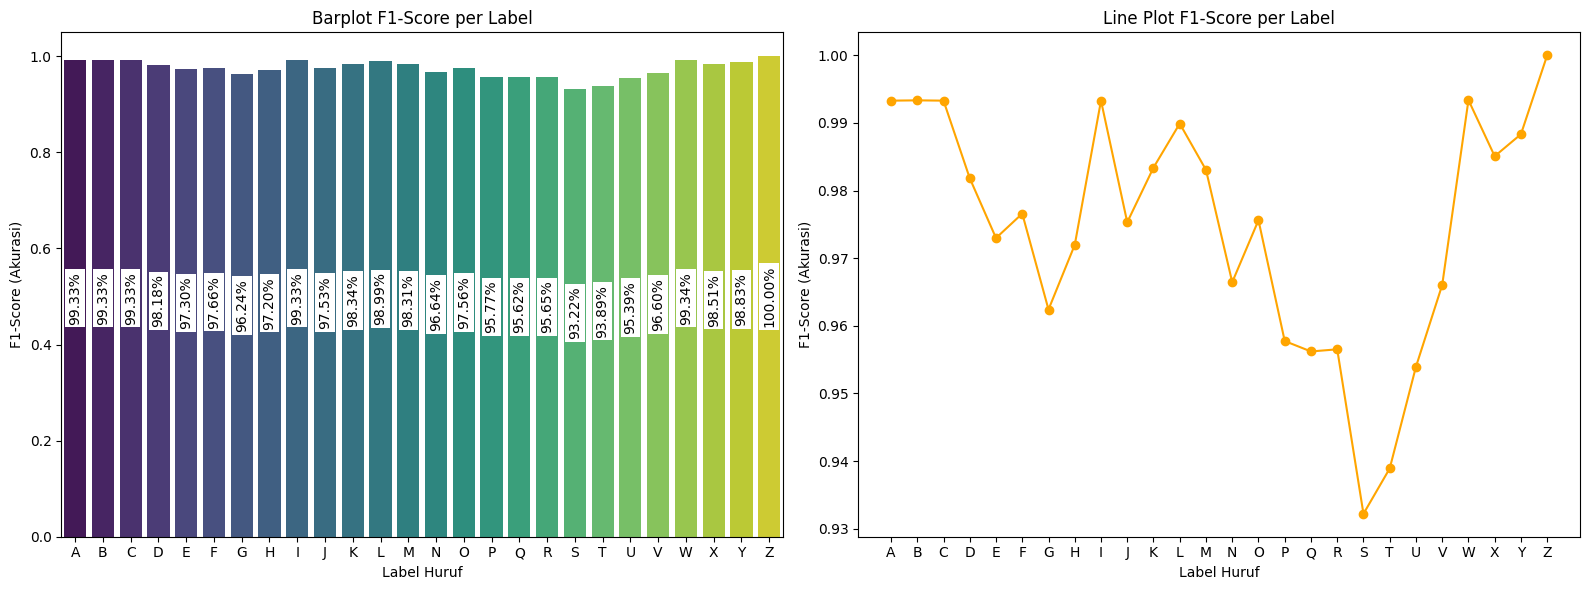

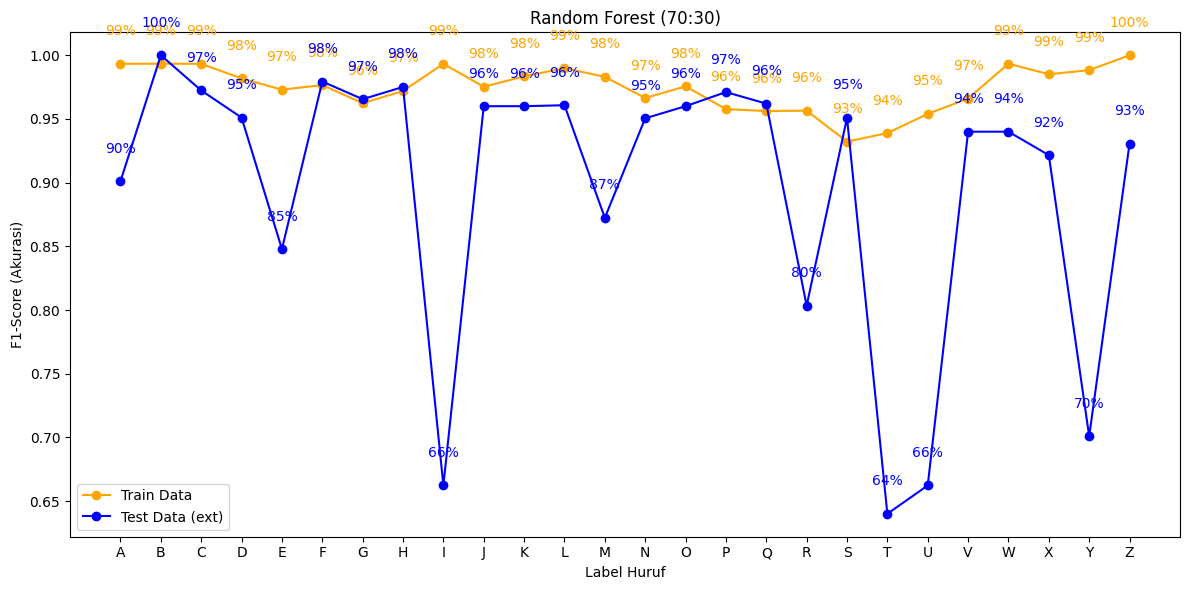

In [ ]:
# --- Random Forest (70 : 30)

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier()

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70:30)')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


97.92099792099792% of samples were classified correctly !
{'A': {'precision': 0.9900990099009901, 'recall': 1.0, 'f1-score': 0.9950248756218906, 'support': 100.0}, 'B': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 100.0}, 'C': {'precision': 0.9801980198019802, 'recall': 1.0, 'f1-score': 0.99, 'support': 99.0}, 'D': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92.0}, 'E': {'precision': 0.9897959183673469, 'recall': 0.97, 'f1-score': 0.9797979797979798, 'support': 100.0}, 'F': {'precision': 0.9896907216494846, 'recall': 0.9795918367346939, 'f1-score': 0.9846153846153847, 'support': 98.0}, 'G': {'precision': 0.9882352941176471, 'recall': 0.9655172413793104, 'f1-score': 0.9767441860465116, 'support': 87.0}, 'H': {'precision': 0.9722222222222222, 'recall': 0.9722222222222222, 'f1-score': 0.9722222222222222, 'support': 72.0}, 'I': {'precision': 0.98989898989899, 'recall': 0.98989898989899, 'f1-score': 0.98989898989899, 'support': 99.0}, 'J': {'precision':

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\130499116.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


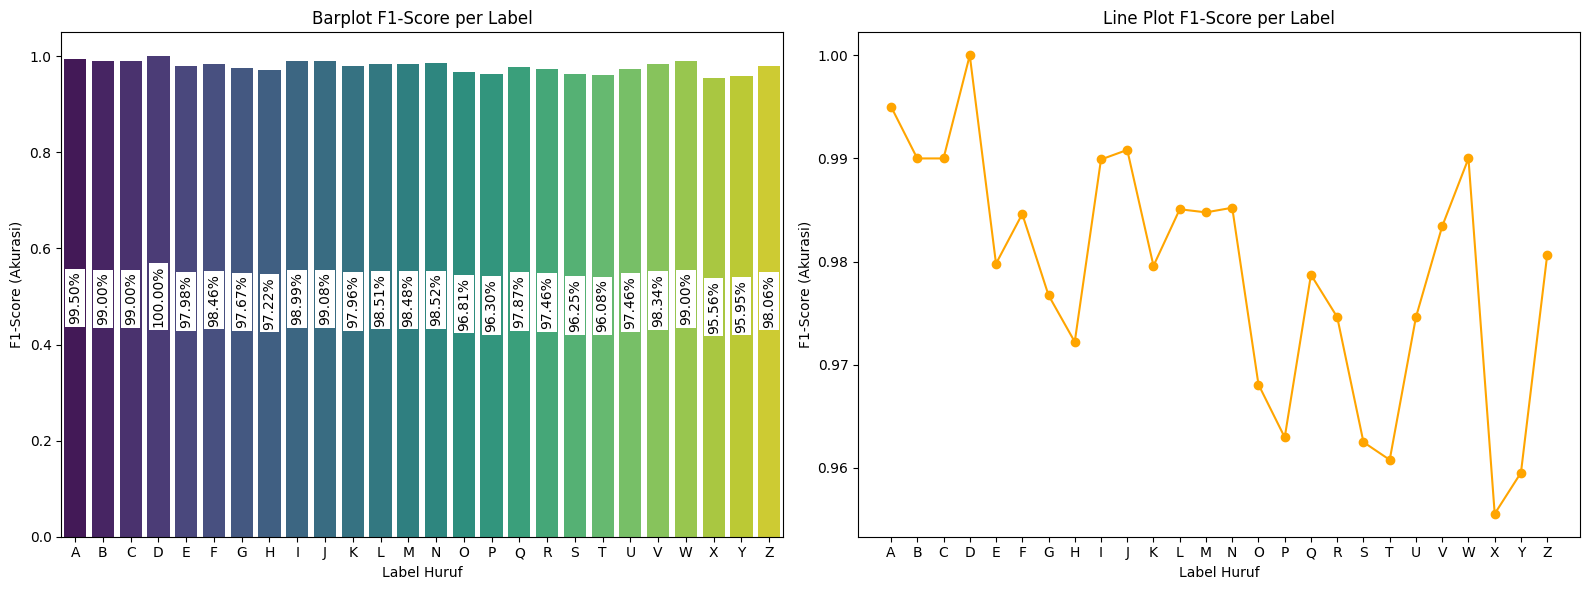

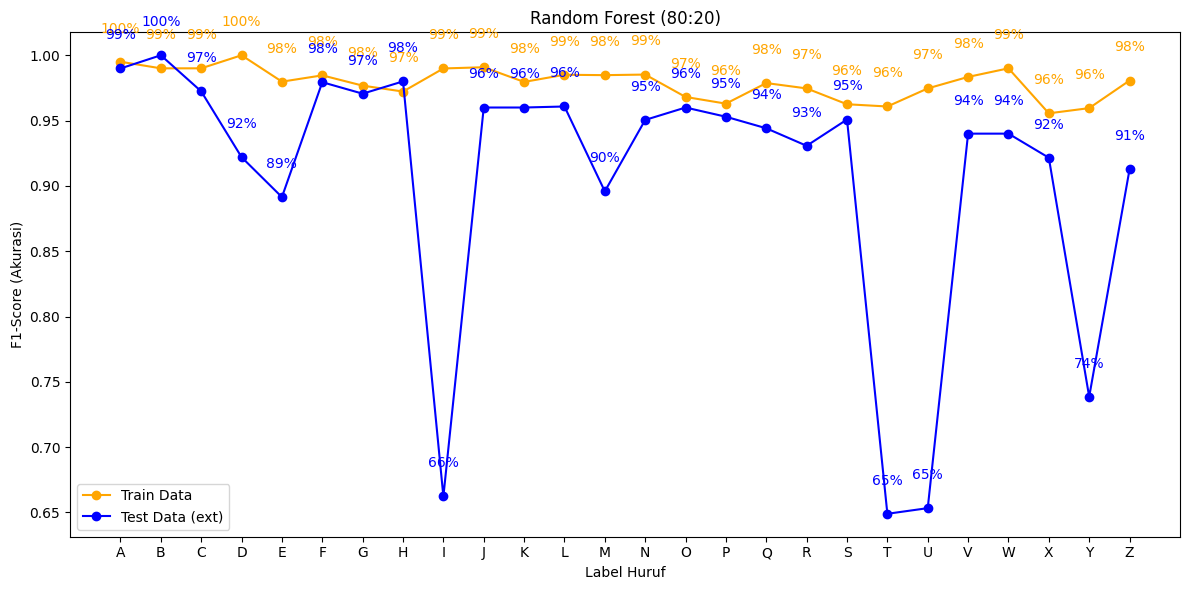

In [ ]:
# --- Random Forest (80 : 20)

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier()

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_82.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_82_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (80:20)')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


97.44940393678958% of samples were classified correctly !
{'A': {'precision': 0.9738562091503268, 'recall': 0.9933333333333333, 'f1-score': 0.9834983498349835, 'support': 150.0}, 'B': {'precision': 0.9738562091503268, 'recall': 0.9933333333333333, 'f1-score': 0.9834983498349835, 'support': 150.0}, 'C': {'precision': 0.9865771812080537, 'recall': 0.9932432432432432, 'f1-score': 0.98989898989899, 'support': 148.0}, 'D': {'precision': 0.9927536231884058, 'recall': 0.9856115107913669, 'f1-score': 0.9891696750902527, 'support': 139.0}, 'E': {'precision': 0.9930555555555556, 'recall': 0.959731543624161, 'f1-score': 0.9761092150170648, 'support': 149.0}, 'F': {'precision': 0.9859154929577465, 'recall': 0.9459459459459459, 'f1-score': 0.9655172413793104, 'support': 148.0}, 'G': {'precision': 0.9485294117647058, 'recall': 0.9923076923076923, 'f1-score': 0.9699248120300752, 'support': 130.0}, 'H': {'precision': 0.9903846153846154, 'recall': 0.9537037037037037, 'f1-score': 0.9716981132075472, 'su

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\1594754035.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


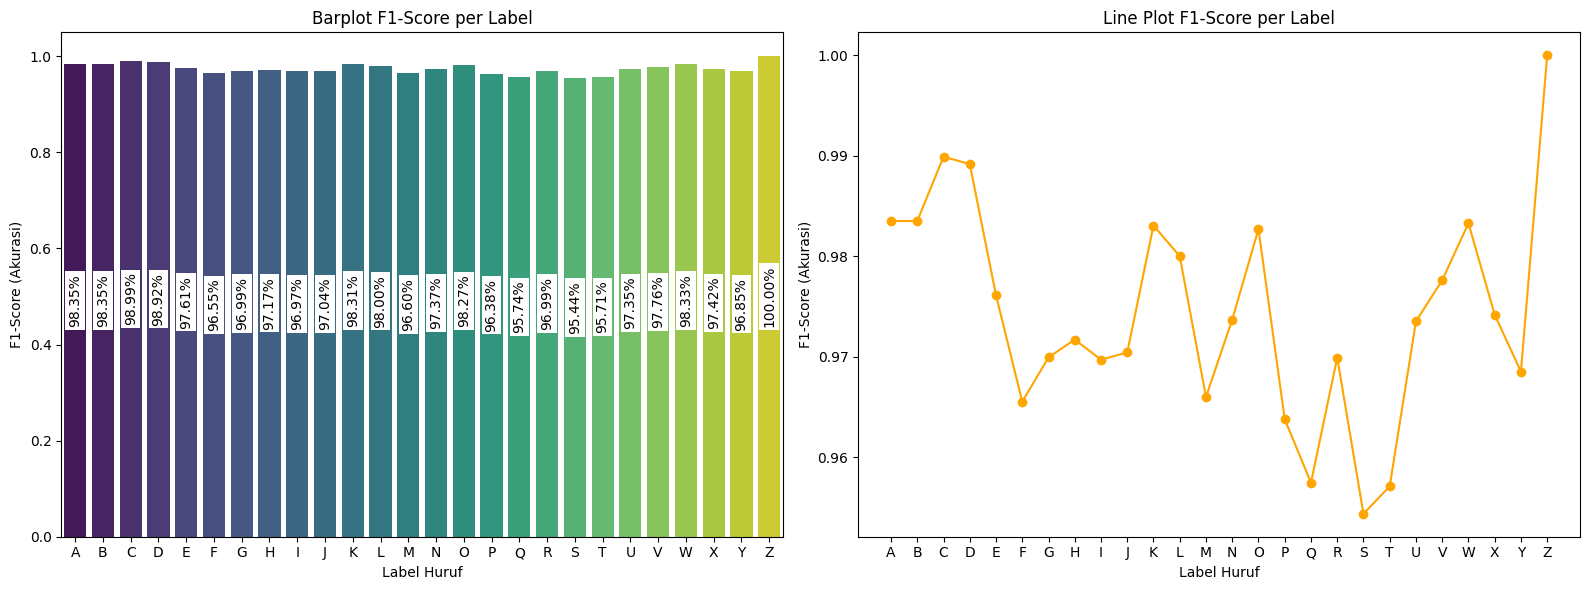

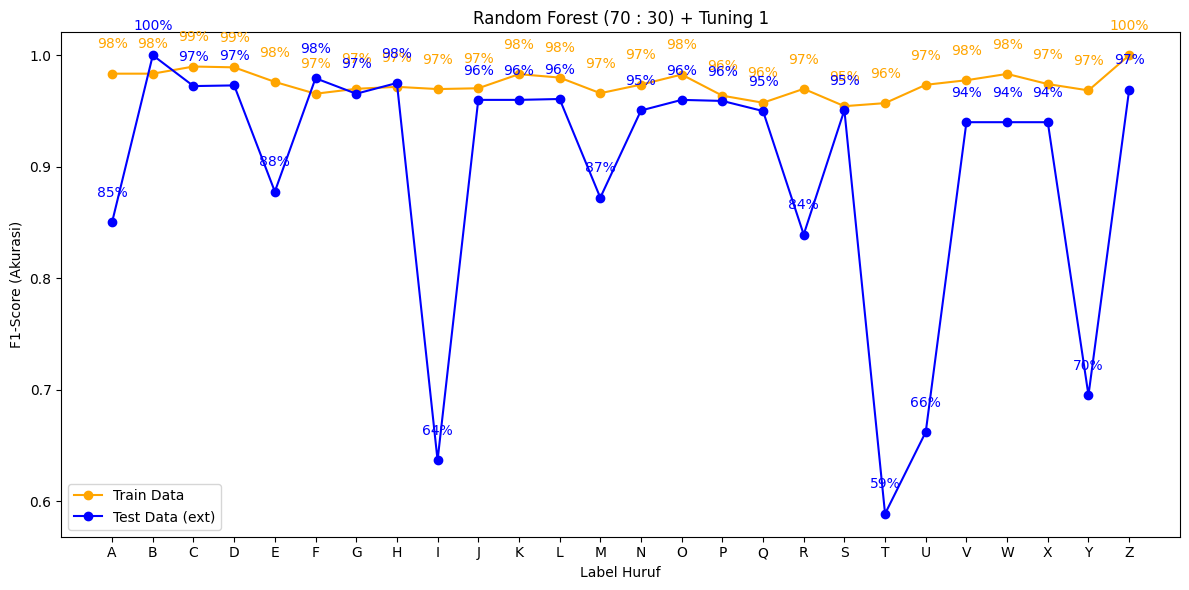

In [ ]:
# --- Random Forest (70 : 30) + Tuning 1

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=200,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=20,             # Maksimal kedalaman tiap pohon
    min_samples_split=5,      # Minimum sampel untuk split internal node
    min_samples_leaf=2,       # Minimum sampel untuk leaf node
    max_features='sqrt',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_tn1_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70 : 30) + Tuning 1')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


96.50679234821182% of samples were classified correctly !
{'A': {'precision': 0.9802631578947368, 'recall': 0.9933333333333333, 'f1-score': 0.9867549668874173, 'support': 150.0}, 'B': {'precision': 1.0, 'recall': 0.9933333333333333, 'f1-score': 0.9966555183946488, 'support': 150.0}, 'C': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 148.0}, 'D': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 139.0}, 'E': {'precision': 0.9931506849315068, 'recall': 0.9731543624161074, 'f1-score': 0.9830508474576272, 'support': 149.0}, 'F': {'precision': 0.9863013698630136, 'recall': 0.972972972972973, 'f1-score': 0.9795918367346939, 'support': 148.0}, 'G': {'precision': 0.9626865671641791, 'recall': 0.9923076923076923, 'f1-score': 0.9772727272727273, 'support': 130.0}, 'H': {'precision': 0.9809523809523809, 'recall': 0.9537037037037037, 'f1-score': 0.9671361502347418, 'support': 108.0}, 'I': {'precision': 0.9607843137254902, 'recall': 0.9865771812080537, 'f1-score': 0.9735

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\2861727807.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


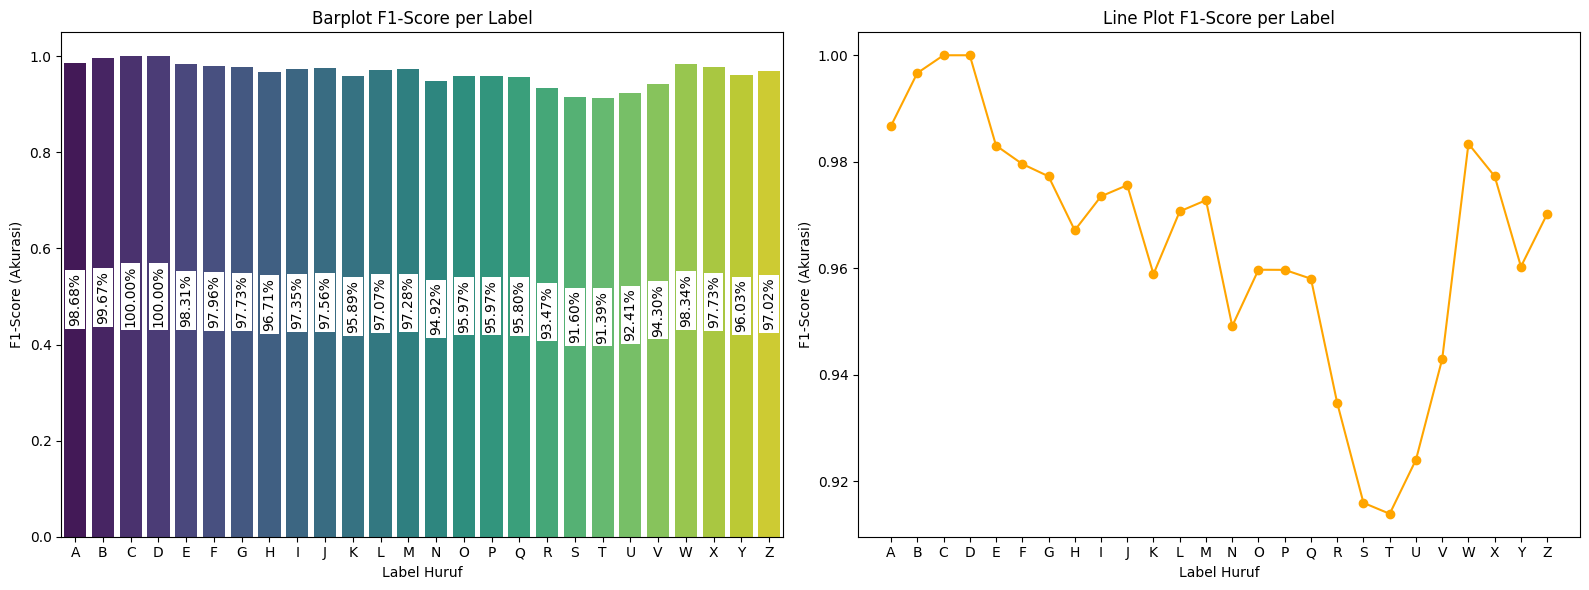

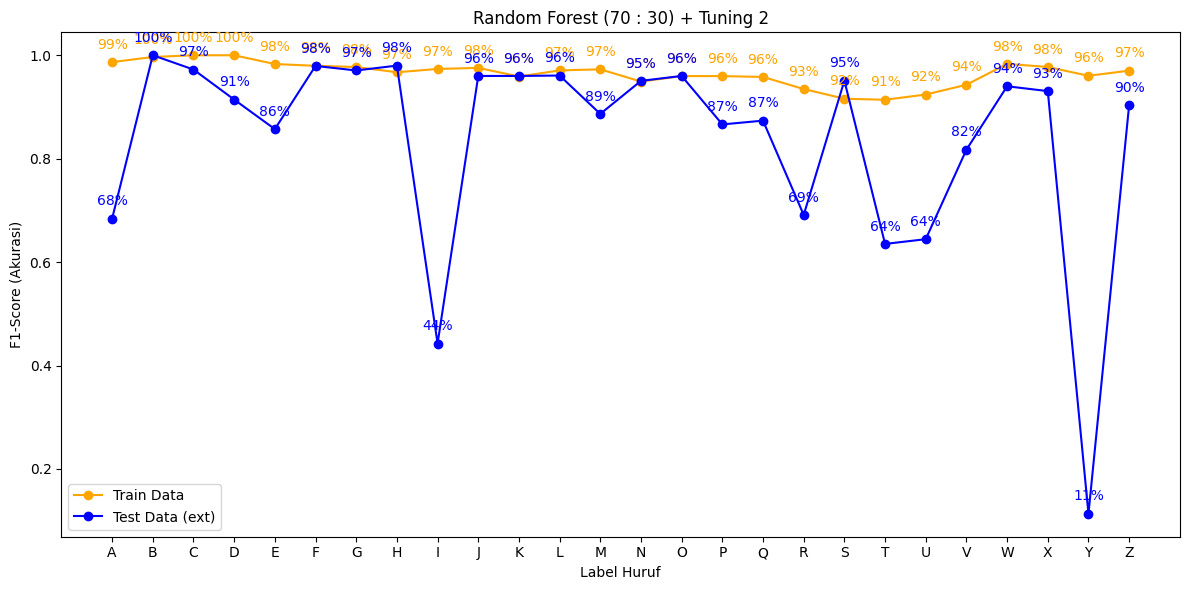

In [ ]:
# --- Random Forest (70 : 30) + Tuning 2

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=300,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=25,             # Maksimal kedalaman tiap pohon
    min_samples_split=10,      # Minimum sampel untuk split internal node
    min_samples_leaf=4,       # Minimum sampel untuk leaf node
    max_features='log2',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_73_tn2.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_73_tn2_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (70 : 30) + Tuning 2')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


97.25571725571726% of samples were classified correctly !
{'A': {'precision': 0.9705882352941176, 'recall': 0.99, 'f1-score': 0.9801980198019802, 'support': 100.0}, 'B': {'precision': 0.9900990099009901, 'recall': 1.0, 'f1-score': 0.9950248756218906, 'support': 100.0}, 'C': {'precision': 1.0, 'recall': 0.98989898989899, 'f1-score': 0.9949238578680203, 'support': 99.0}, 'D': {'precision': 0.9891304347826086, 'recall': 0.9891304347826086, 'f1-score': 0.9891304347826086, 'support': 92.0}, 'E': {'precision': 0.9896907216494846, 'recall': 0.96, 'f1-score': 0.9746192893401016, 'support': 100.0}, 'F': {'precision': 0.9893617021276596, 'recall': 0.9489795918367347, 'f1-score': 0.96875, 'support': 98.0}, 'G': {'precision': 0.945054945054945, 'recall': 0.9885057471264368, 'f1-score': 0.9662921348314607, 'support': 87.0}, 'H': {'precision': 0.971830985915493, 'recall': 0.9583333333333334, 'f1-score': 0.965034965034965, 'support': 72.0}, 'I': {'precision': 0.97, 'recall': 0.9797979797979798, 'f1-s

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\1716568682.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


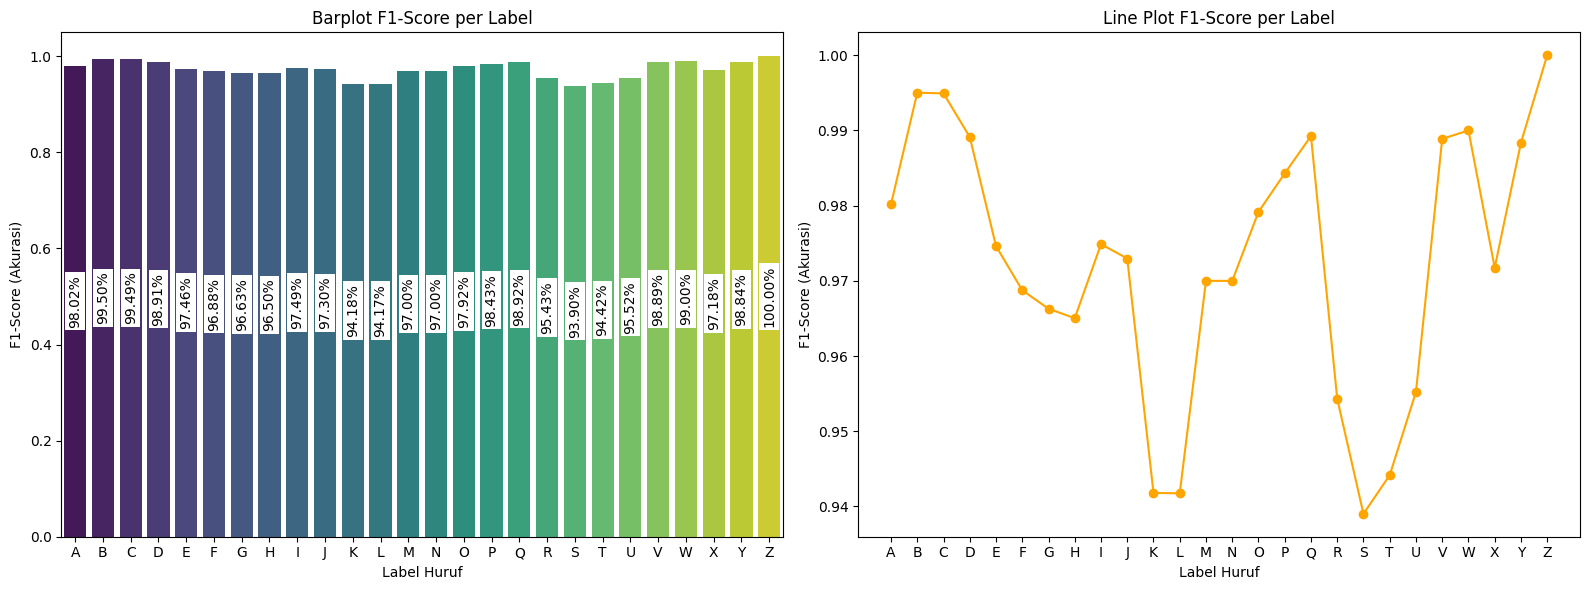

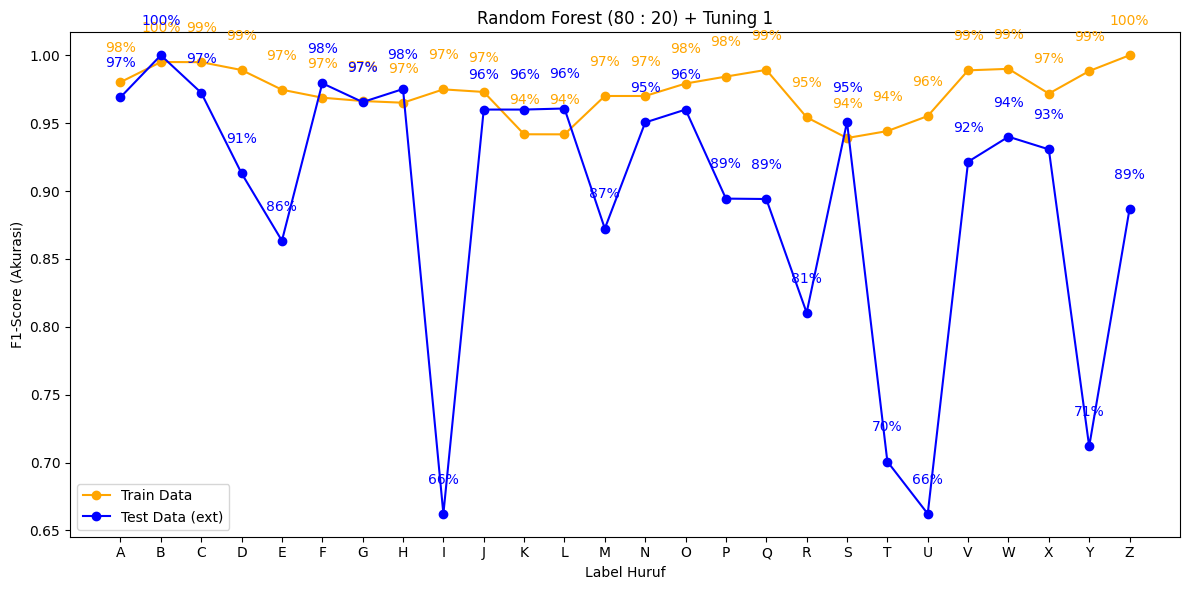

In [59]:
# --- Random Forest (80 : 20) + Tuning 1

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=200,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=20,             # Maksimal kedalaman tiap pohon
    min_samples_split=5,      # Minimum sampel untuk split internal node
    min_samples_leaf=2,       # Minimum sampel untuk leaf node
    max_features='sqrt',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_82_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_82_tn1_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (80 : 20) + Tuning 1')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


96.96465696465697% of samples were classified correctly !
{'A': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 100.0}, 'B': {'precision': 0.9900990099009901, 'recall': 1.0, 'f1-score': 0.9950248756218906, 'support': 100.0}, 'C': {'precision': 1.0, 'recall': 0.98989898989899, 'f1-score': 0.9949238578680203, 'support': 99.0}, 'D': {'precision': 0.989010989010989, 'recall': 0.9782608695652174, 'f1-score': 0.9836065573770492, 'support': 92.0}, 'E': {'precision': 0.9795918367346939, 'recall': 0.96, 'f1-score': 0.9696969696969697, 'support': 100.0}, 'F': {'precision': 0.9795918367346939, 'recall': 0.9795918367346939, 'f1-score': 0.9795918367346939, 'support': 98.0}, 'G': {'precision': 0.9885057471264368, 'recall': 0.9885057471264368, 'f1-score': 0.9885057471264368, 'support': 87.0}, 'H': {'precision': 0.9861111111111112, 'recall': 0.9861111111111112, 'f1-score': 0.9861111111111112, 'support': 72.0}, 'I': {'precision': 0.9795918367346939, 'recall':

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\3661416636.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


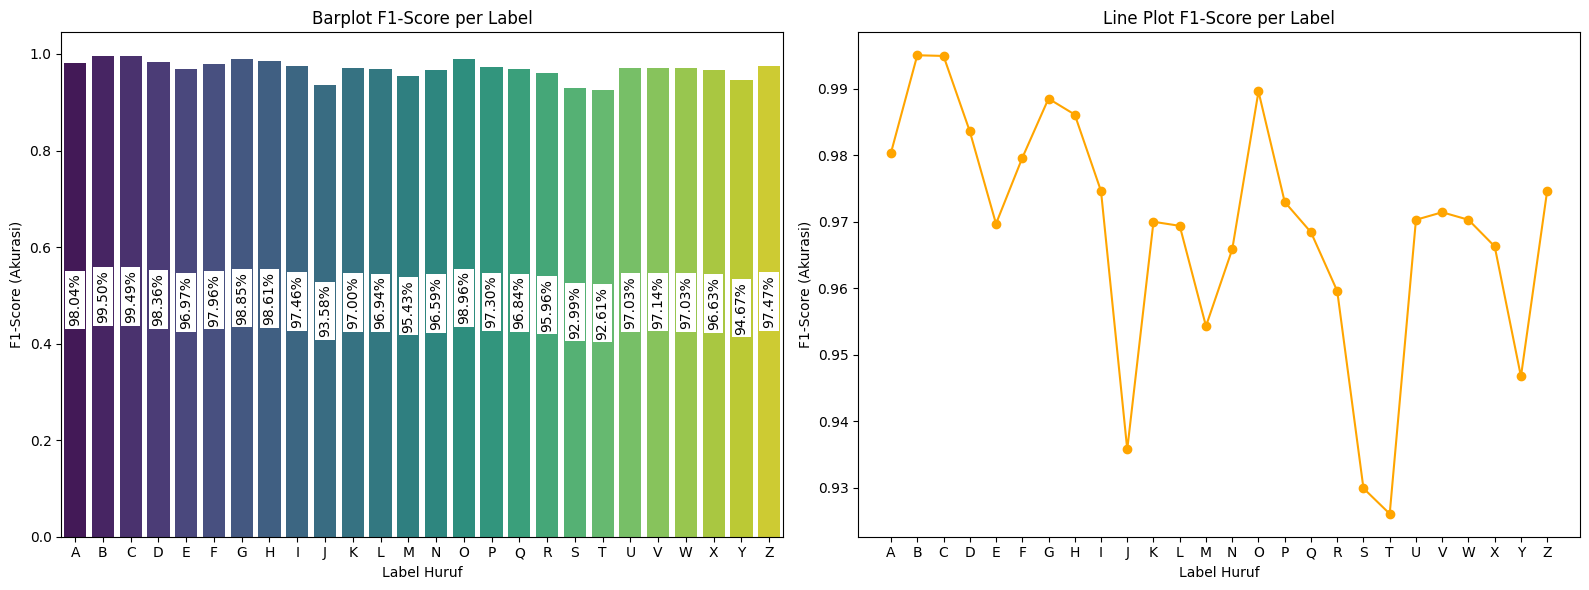

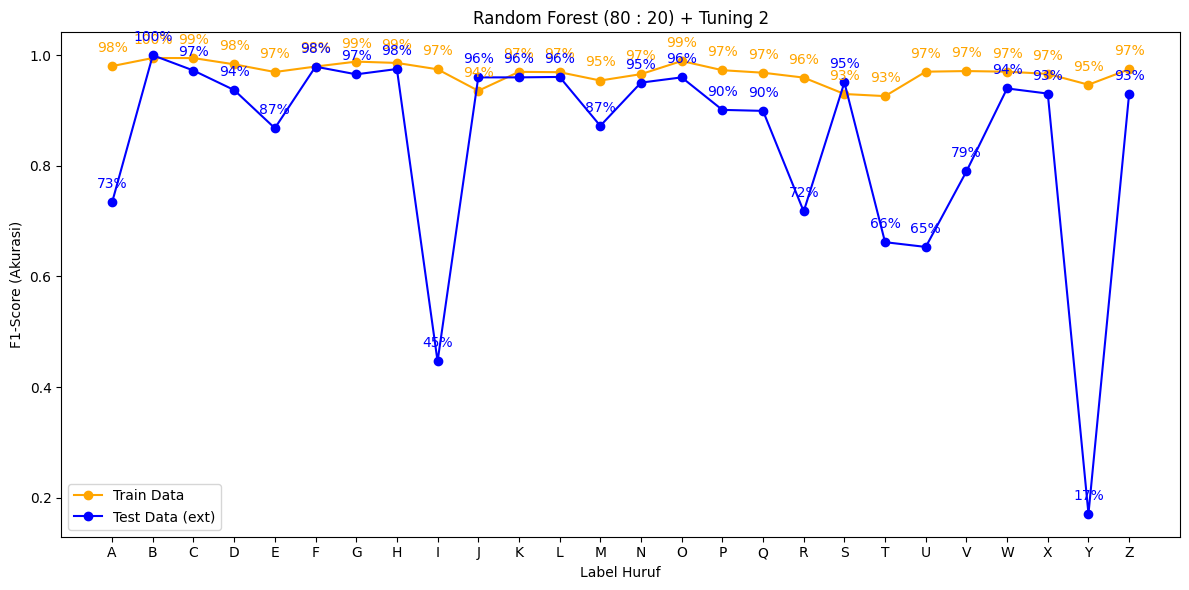

In [60]:
# --- Random Forest (80 : 20) + Tuning 2

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
model = RandomForestClassifier(
    n_estimators=300,         # Jumlah pohon, bisa dicoba 100-500
    max_depth=25,             # Maksimal kedalaman tiap pohon
    min_samples_split=10,      # Minimum sampel untuk split internal node
    min_samples_leaf=4,       # Minimum sampel untuk leaf node
    max_features='log2',      # Fitur yang dipilih saat split
    bootstrap=True,           # Gunakan bootstrap sampling
    random_state=42,          # Untuk reproduksibilitas
    n_jobs=-1                 # Gunakan semua core CPU
)

# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_82_tn2.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_82_tn2_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest (80 : 20) + Tuning 2')
# plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


97.64347102855558% of samples were classified correctly !
{'A': {'precision': 0.9933333333333333, 'recall': 0.9933333333333333, 'f1-score': 0.9933333333333333, 'support': 150.0}, 'B': {'precision': 0.9867549668874173, 'recall': 0.9933333333333333, 'f1-score': 0.9900332225913622, 'support': 150.0}, 'C': {'precision': 0.9932432432432432, 'recall': 0.9932432432432432, 'f1-score': 0.9932432432432432, 'support': 148.0}, 'D': {'precision': 0.9928057553956835, 'recall': 0.9928057553956835, 'f1-score': 0.9928057553956835, 'support': 139.0}, 'E': {'precision': 0.9931506849315068, 'recall': 0.9731543624161074, 'f1-score': 0.9830508474576272, 'support': 149.0}, 'F': {'precision': 0.9797297297297297, 'recall': 0.9797297297297297, 'f1-score': 0.9797297297297297, 'support': 148.0}, 'G': {'precision': 0.9770992366412213, 'recall': 0.9846153846153847, 'f1-score': 0.9808429118773946, 'support': 130.0}, 'H': {'precision': 0.9724770642201835, 'recall': 0.9814814814814815, 'f1-score': 0.9769585253456221, 

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\2889904359.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])


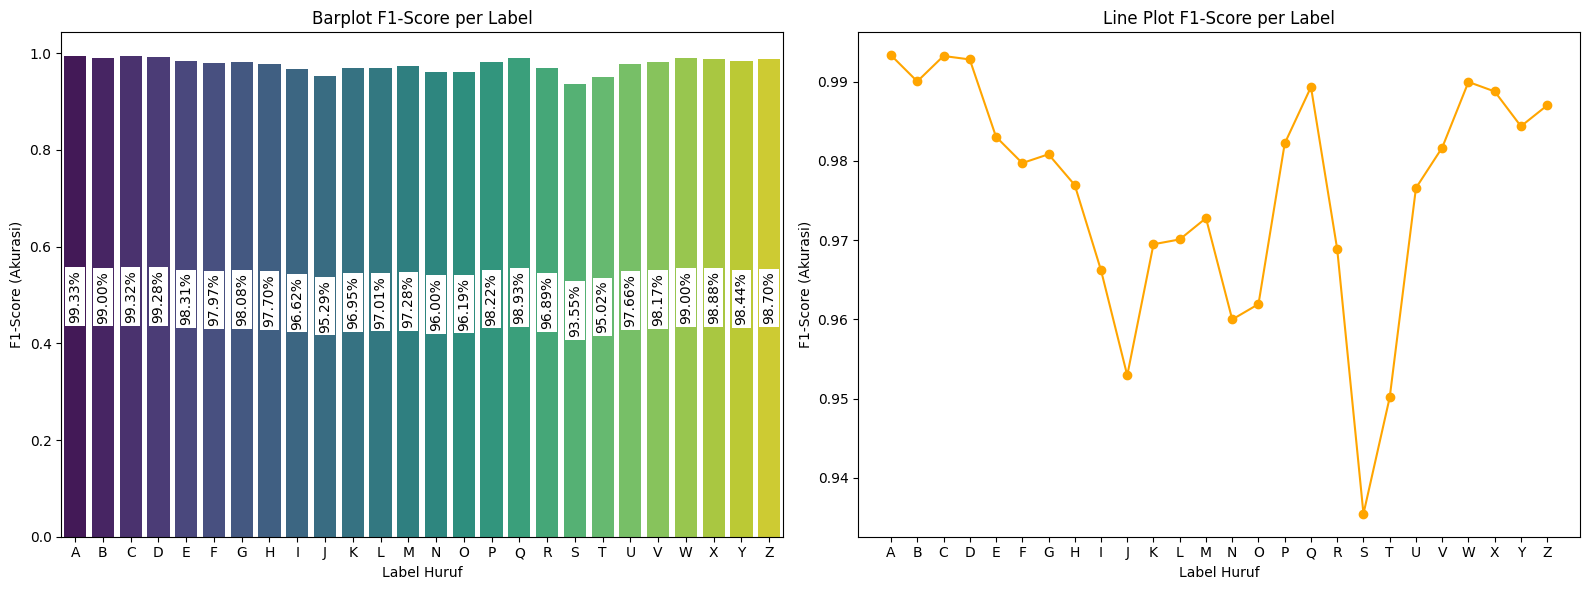

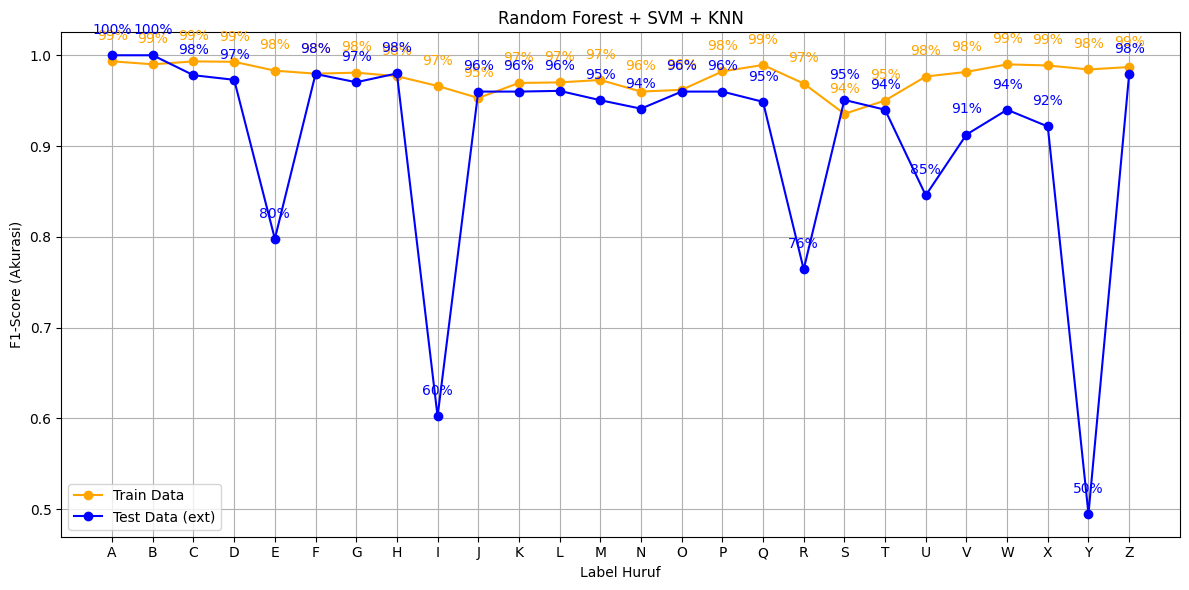

In [63]:
# --- Random Forest + SVM + KNN

import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Periksa bentuk dari setiap elemen dalam data_dict['data']
# Buat daftar untuk menyimpan data yang valid
valid_data = []

for sample in data_dict['data']:
    if len(sample) == 42:  # Pastikan panjang fitur adalah 42
        valid_data.append(sample)

# Konversi ke array NumPy
data = np.array(valid_data)  # Harus berukuran (n_samples, 42)
labels = np.array(data_dict['labels'][:len(valid_data)])  # Sesuaikan dengan jumlah data valid

# Membuat labels_dict untuk pemetaan huruf
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, shuffle=True, stratify=labels)

# Inisialisasi dan latih model
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True)),
    ('knn', KNeighborsClassifier())
], voting='soft')


# Data sudah memiliki bentuk yang sesuai
model.fit(x_train, y_train)

# Prediksi dan hitung skor akurasi
y_predict = model.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly !'.format(score * 100))

# Cek apakah file model.p sudah ada
model_filename = 'model.p'
if os.path.exists(model_filename):
    # Jika ada, rename menjadi model1.p, model2.p, dst.
    i = 1
    new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    while os.path.exists(new_filename):
        i += 1
        new_filename = f'{os.path.splitext(model_filename)[0]}{i}{os.path.splitext(model_filename)[1]}'
    os.rename(model_filename, new_filename)

# Tentukan folder untuk menyimpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Tentukan nama file model dengan increment
i = 1
model_filename = os.path.join(model_folder, 'rf_model_svm_knn.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_svm_knn_{i}.p')
    i += 1

# Simpan model ke file
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model}, f)

# Generate classification report
report = classification_report(y_test, y_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)
print(report)

# Ekstraksi akurasi (f1-score) untuk setiap kelas
class_names = list(sorted(labels_dict.values()))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]

# Membuat DataFrame untuk seaborn
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

# Buat 1 baris 2 kolom subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Barplot di axes[0] ===
sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Label Huruf')
axes[0].set_ylabel('F1-Score (Akurasi)')
axes[0].set_title('Barplot F1-Score per Label')

# Tambahkan nilai F1 pada batang barplot
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height / 2.,
                 '{:1.2f}%'.format(height * 100),
                 ha='center', va='center', rotation='vertical',
                 bbox=dict(facecolor='white', edgecolor='none', pad=2))

# === Line plot di axes[1] ===
axes[1].plot(df_report['Label'], df_report['F1-Score'], linestyle='-', color='orange', marker='o')
axes[1].set_xlabel('Label Huruf')
axes[1].set_ylabel('F1-Score (Akurasi)')
axes[1].set_title('Line Plot F1-Score per Label')

plt.tight_layout()
plt.show()

# === LOAD DAN EVALUASI TEST DATA EKSTERNAL ===
# Muat test data dari file test_data.pickle
test_data_dict = pickle.load(open('../test_data.pickle', 'rb'))

# Filter dan validasi data test (harus panjang fitur = 42)
valid_test_data = [sample for sample in test_data_dict['data'] if len(sample) == 42]

# Pastikan valid_test_data tidak kosong
if not valid_test_data:
    raise ValueError("No valid test data found. Ensure that the test data contains samples with the correct feature length.")

test_data = np.array(valid_test_data)
test_labels = np.array(test_data_dict['labels'][:len(valid_test_data)])

# Prediksi test data eksternal
test_predict = model.predict(test_data)

# Classification report untuk test data
external_report = classification_report(test_labels, test_predict, target_names=[labels_dict[i] for i in sorted(labels_dict.keys())], output_dict=True)

# Ekstraksi F1-score dari test data
f1_scores_external = [external_report[class_name]['f1-score'] for class_name in class_names]

# === LINE PLOT PERBANDINGAN ===
plt.figure(figsize=(12, 6))
plt.plot(df_report['Label'], df_report['F1-Score'], marker='o', linestyle='-', color='orange', label='Train Data')
plt.plot(df_report['Label'], f1_scores_external, marker='o', linestyle='-', color='blue', label='Test Data (ext)')

# Label dan title
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Random Forest + SVM + KNN')
plt.grid(True)
plt.legend()

# Tambahkan nilai di atas titik untuk kedua garis
for x, y1, y2 in zip(df_report['Label'], df_report['F1-Score'], f1_scores_external):
    plt.text(x, y1 + 0.02, f'{y1*100:.0f}%', ha='center', va='bottom', color='orange')
    plt.text(x, y2 + 0.02, f'{y2*100:.0f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()


Fold 1 Accuracy: 0.9869
Fold 2 Accuracy: 0.9703
Fold 3 Accuracy: 0.9786
Fold 4 Accuracy: 0.9798
Fold 5 Accuracy: 0.9750
Fold 6 Accuracy: 0.9738
Fold 7 Accuracy: 0.9750
Fold 8 Accuracy: 0.9608
Fold 9 Accuracy: 0.9691
Fold 10 Accuracy: 0.9881

Mean K-Fold Accuracy: 0.9757531894221618
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.99      1.00      0.99       350
           B       0.99      1.00      1.00       350
           C       0.99      0.99      0.99       346
           D       0.99      0.99      0.99       323
           E       0.99      0.96      0.98       348
           F       0.98      0.99      0.98       344
           G       0.97      0.98      0.98       304
           H       0.97      0.97      0.97       251
           I       0.98      0.98      0.98       348
           J       0.97      0.97      0.97       193
           K       0.97      0.96      0.97       347
           L       0.97      0.97  

C:\Users\ACER\AppData\Local\Temp\ipykernel_19824\2295812833.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis')


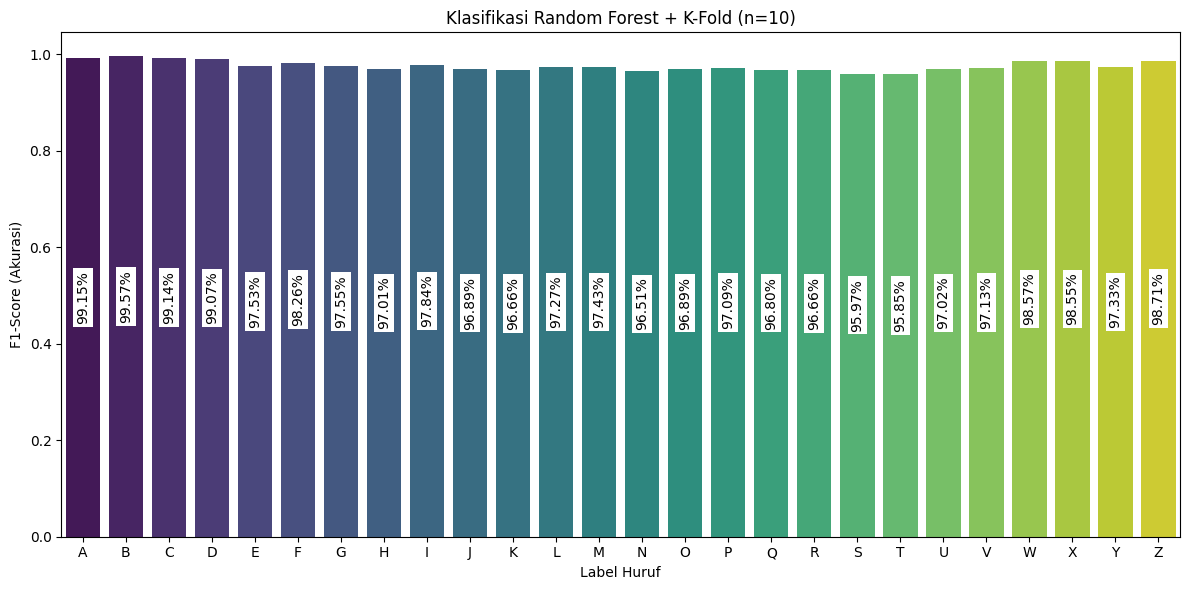

Final Test Accuracy: 0.9742168006653729
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.96      0.99      0.97       150
           B       0.98      0.99      0.98       150
           C       0.98      0.99      0.99       148
           D       0.99      0.98      0.99       139
           E       0.98      0.97      0.97       150
           F       1.00      0.97      0.98       148
           G       0.96      1.00      0.98       130
           H       0.99      0.95      0.97       108
           I       0.97      0.99      0.98       149
           J       0.99      0.96      0.98        83
           K       0.99      1.00      1.00       149
           L       0.99      0.99      0.99       149
           M       0.97      0.98      0.97       149
           N       0.97      0.95      0.96       149
           O       0.93      0.97      0.95       144
           P       0.98      0.93      0.95       140
     

In [18]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data
data_dict = pickle.load(open('../train_data.pickle', 'rb'))

# Filter hanya data dengan panjang fitur 42
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])

# Label dictionary
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}

# Split train-test
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
all_y_true = []
all_y_pred = []
final_model = None

# Cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_index], x_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

    final_model = model  # simpan model dari fold terakhir

# Rata-rata akurasi K-Fold
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

# Classification report untuk hasil K-Fold
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]
report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

# Visualisasi F1-Score per kelas
f1_scores = [report_dict[label]['f1-score'] for label in class_names]
df_report = pd.DataFrame({'Label': class_names, 'F1-Score': f1_scores})

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='F1-Score', data=df_report, palette='viridis')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score (Akurasi)')
plt.title('Klasifikasi Random Forest + K-Fold (n=10)')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height / 2.,
            '{:1.2f}%'.format(height * 100),
            ha='center', va='center', rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.tight_layout()
plt.show()

# Evaluasi pada test set
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Final Test Accuracy:", test_acc)

# Classification report untuk test set
report_test = classification_report(y_test, y_test_pred, target_names=class_names)
print("Classification Report (Test Data):\n", report_test)

# Simpan model
model_folder = '../model/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)
